# Handwriting Recognition: <br> World Vision Project

### Camilo Salazar <br> October 7th 2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout

# Data Cleaning

In [2]:
# load Data
train = pd.read_csv('data/written_name_train_v2.csv')
validation = pd.read_csv('data/written_name_validation_v2.csv')

In [3]:
train.head(10)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
5,TRAIN_00006.jpg,LUCIE
6,TRAIN_00007.jpg,NASSIM
7,TRAIN_00008.jpg,ASSRAOUI
8,TRAIN_00009.jpg,LAVIAN
9,TRAIN_00010.jpg,MAEVA


In [4]:
validation.head(10)

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
5,VALIDATION_0006.jpg,UNREADABLE
6,VALIDATION_0007.jpg,PICHON
7,VALIDATION_0008.jpg,DANIEL
8,VALIDATION_0009.jpg,JEREMY
9,VALIDATION_0010.jpg,JEAN-MICHEL


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [6]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41292 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [7]:
print("Number of Missing Values in train set      is ", train['IDENTITY'].isna().sum())
print("Number of Missing Values in validation set is ", validation['IDENTITY'].isna().sum())

Number of Missing Values in train set      is  565
Number of Missing Values in validation set is  78


In [8]:
train.dropna(axis=0, inplace=True)
validation.dropna(axis=0, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330396 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330396 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [9]:
train['IDENTITY'].value_counts().head(10)

IDENTITY
THOMAS     1825
EMPTY      1796
LEA        1582
EMMA       1482
LUCAS      1479
HUGO       1367
CAMILLE    1367
CLEMENT    1313
MANON      1277
LOUIS      1257
Name: count, dtype: int64

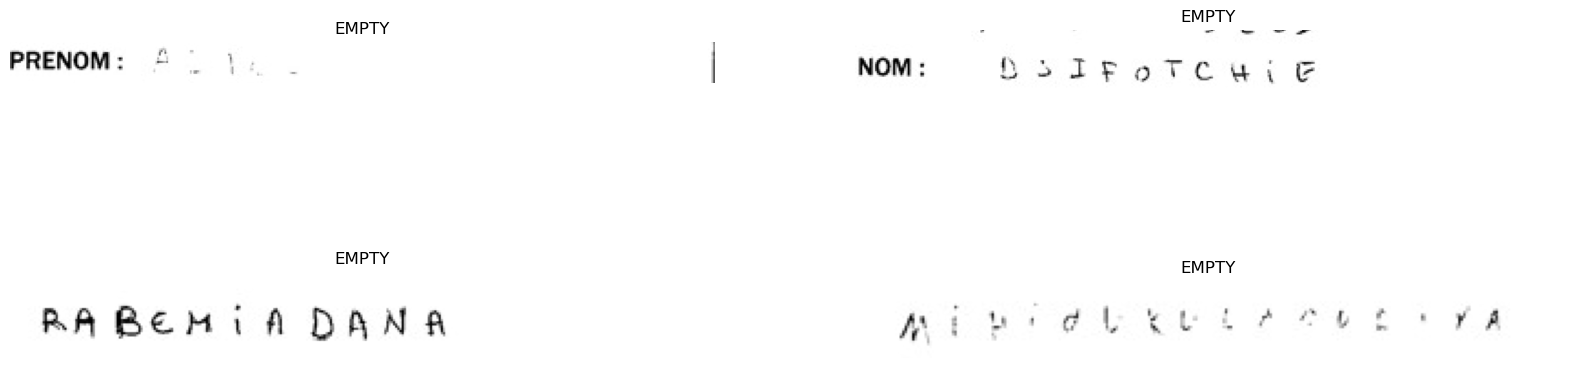

In [10]:
empty_train = train[train['IDENTITY'] == 'EMPTY']

plt.figure(figsize=(20, 20))
for i in range(0,4):
    ax = plt.subplot(2, 2, i+1)
    image = cv2.imread('data/train/' +empty_train.iloc[i,0] , cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(empty_train.iloc[i,1])
    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [11]:
train = train[train['IDENTITY'] != 'EMPTY']
validation = validation[validation['IDENTITY'] != 'EMPTY']

train['IDENTITY'].value_counts().head(10)

IDENTITY
THOMAS     1825
LEA        1582
EMMA       1482
LUCAS      1479
HUGO       1367
CAMILLE    1367
CLEMENT    1313
MANON      1277
LOUIS      1257
THEO       1214
Name: count, dtype: int64

In [72]:
print('Length of Longest String in IDENTITY  : ' + str(train['IDENTITY'].str.len().max()))

Length of Longest String in IDENTITY  : 34


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328600 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  328600 non-null  object
 1   IDENTITY  328600 non-null  object
dtypes: object(2)
memory usage: 7.5+ MB


In [13]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41105 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41105 non-null  object
 1   IDENTITY  41105 non-null  object
dtypes: object(2)
memory usage: 963.4+ KB


# Data Preprocessing

In [52]:
def format_image(image):
    (h,w) = image.shape
    final_image = np.ones([64, 256])*255
    if w > 256:
        image = image[:, :256]
        
    if h > 64:
        image = image[:64, :]
    final_image[:h,:w] = image
    final_image = cv2.rotate(final_image, cv2.ROTATE_90_CLOCKWISE)
    return final_image

In [38]:
train.reset_index(inplace = True, drop=True) 
validation.reset_index(inplace = True, drop=True)

train_size = 50000
validation_size = 5000

In [64]:
train_x = []
for i in range(train_size):
    image = cv2.imread('data/train/' +train.iloc[1,0], cv2.IMREAD_GRAYSCALE)
    image = format_image(image)/255
    train_x.append(image)

In [95]:
validation_x = []
for i in range(validation_size):
    image = cv2.imread('data/validation/' +validation.iloc[1,0], cv2.IMREAD_GRAYSCALE)
    image = format_image(image)/255
    train_x.append(image)

In [78]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_string_lenght = 34

def label_to_nums(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
    return np.array(label_num)



In [97]:
train_y = np.ones([train_size,max_string_lenght])* -1
validation_y = np.ones([validation_size,max_string_lenght])* -1
for i in range(train_size):
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_nums(train.loc[i, 'IDENTITY'])

for i in range(validation_size):
    validation_y[i, 0:len(validation.loc[i, 'IDENTITY'])]= label_to_nums(validation.loc[i, 'IDENTITY'])